In [1]:
import torch.nn.functional as F
import torch
from torch import nn
from dataset import load_dataset
from training_loop import train_model
from basic_unet import UNet
from torchvision import transforms
from torch import optim
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('visual_attribution')
from explainer.gradcam import GradCAMExplainer
from torch.autograd import Variable
import numpy as np
from torch.nn.functional import interpolate

In [2]:
batch_size = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = load_dataset(batch_size)
model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/3_basic_unet_flat_criterion_279_0.00000.pth')
model.load_state_dict(state_dict)
model = model.to(device)

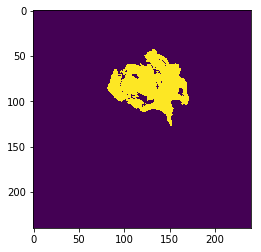

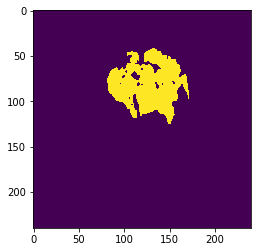

In [3]:
sample = next(iter(test_loader))

segment = sample['segment']
segment = segment.squeeze()
plt.imshow(segment)
plt.show()

image = sample['input'].to(device)
output = model(image)
output = output.detach().cpu().squeeze().numpy()
output = (output > output.mean())
plt.imshow(output)
plt.show()

In [4]:
class FakeModel():
    def __init__(self, real_model, x, y):
        self.real_model = real_model
        self.x = x
        self.y = y
        self._modules = self.real_model._modules

    def __call__(self, *args, **kwargs):
        output = self.real_model(*args, **kwargs)
        x = output[0][self.x][self.y]
        x = x.unsqueeze(0).unsqueeze(0)
        return x


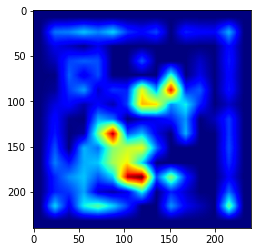

In [5]:
def upsample(inp, size):
    scale = size / inp.shape[3]
    return interpolate(inp, scale_factor=scale, mode='bilinear', align_corners=False)

def explain():
    for x in range(output.shape[0]):
        for y in range(output.shape[1]):
            if output[x][y]:
                fake_model = FakeModel(model, x, y)
                tensor = Variable(image, requires_grad=True)
                explainer = GradCAMExplainer(fake_model, target_layer_name_keys=['enc_conv5', 'batch_norm2'])
                target = torch.LongTensor([0]).to(device)
                saliency = explainer.explain(tensor, target)
                saliency = upsample(saliency, 240)
                attr = np.abs(saliency.cpu().numpy()).max(axis=1).squeeze()
                attr -= attr.min()
                attr /= (attr.max() + 1e-20)
                plt.imshow(attr, cmap='jet')
                plt.show()
                return
explain()